# Creating the Training data

## Getting the data

The needed data to create the dataset will be a font files, to convert them in images using the pillow python module.

The data was extracted form the repository **ar-browser-sudoku** (the reference of this project) by **atomic14**, which did a package with diferent fonts from **google fonts**.

Whit this package will construct a dataset of diferent font digits to train a tensorflow model.

In [ ]:
! wget https://github.com/atomic14/ar-browser-sudoku/raw/master/tensorflow/fonts/google.zip

--2022-09-20 00:13:18--  https://github.com/atomic14/ar-browser-sudoku/raw/master/tensorflow/fonts/google.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomic14/ar-browser-sudoku/master/tensorflow/fonts/google.zip [following]
--2022-09-20 00:13:18--  https://raw.githubusercontent.com/atomic14/ar-browser-sudoku/master/tensorflow/fonts/google.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35090283 (33M) [application/zip]
Saving to: ‘google.zip’

google.zip          100%[===================>]  33.46M   177MB/s    in 0.2s    

2022-09-20 00:13:19 (177 MB/s) - ‘google.zip’ saved [35090283/

In [ ]:
! mkdir fonts
! unzip -qq google.zip -d fonts 
! find -type f -name "*.ttf" > fonts/font_list.txt

## Libraries

In [ ]:
! pip install fontTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 5.3 MB/s 


In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageChops
import pandas as pd
import numpy as np
from traitlets.config.application import functools
import matplotlib.pyplot as plt
import pathlib
import os
from fontTools.ttLib import TTFont

## Constant values

In [ ]:
IMG_DIM = 128
FONT_DIRECTORY = '/fonts'
FONT_COLOR = (255, 255, 255)
CHARACTERS = [str(x) for x in range(1,10)]
TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'
FONT_BLACKLIST = [
    '#',
    "italic",
    "Italic",
    "VAZTEK",
    "antique",
    "aztek",
    "RosewoodStd-Regular",
    "ShishoniBrush",
    "VAVOI",
    "seguili",
    'UVNThayGiaoNang_I',
    'VAVOBI',
    'VNI-Nhatban',
    'VNI-Script',
    'VNI-Trung Kien',
    'segoeuii.ttf',
    'VNI-Viettay',
    'Brush',
    'VREDROCK',
    'UVNHaiBaTrung',
    'UVNButLong',
    'AmaticSC',
    'UVNMucCham',
    'UVNThayGiao_BI.TTF',
    'VKUN',
    'segoeuiz.ttf',
    'seguibli.ttf',
    'MyriadPro',
    'Lobster-Regular',
    'Bangers-Regular',
    'VNI',
    'VUSALI.TTF',
    'VPEINOT.TTF',
    'UVNSangSong_R',
    'VDURHAM.TTF',
    'Vnhltfap.ttf',
    'UVNVienDu',
    'UVNBucThu',
    'UVNSangSong',
    'VSCRIPT',
    'VAUCHON',
    'Vnthfap3',
    'VCAMPAI',
    'BungeeOutline',
    'VBROADW',
    'BungeeHairline-Regular',
    'UVNMinhMap',
    'scripti',
    'UVN',
    'brushsbi',
    'Montserrat',
    'VHELVCI.TTF',
    'VFREE',
    'BRUSH'
    'seguis'
    'VSLOGAN.TTF']

## Getting the route of the needed fonts

In [ ]:
def support_digits(font) -> bool :
    font = TTFont(font)
    ascii_codes = [ord(i) for i in CHARACTERS]
    for table in font['cmap'].tables:
        for o in ascii_codes:
            if not o in table.cmap.keys():
                return False
    return True

def isnt_blacklist(font) -> bool:
    return all( map(lambda x: not x in font, FONT_BLACKLIST) )

## Function to create a image with a chcaracter

In [ ]:
def name_file(font_path: str, character) -> str :
    return f'{font_path.split("/")[-1][:-4]}{character}'

def create_image(character: str, font_path: str, destiny_path: str) -> None:
    img = Image.new( mode='RGB', size=(IMG_DIM, IMG_DIM))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, IMG_DIM // 2)
    w, h = draw.textsize(character, font=font)
    draw.text( ( (IMG_DIM - w) // 2, (IMG_DIM - h) // 2 ), character, fill=FONT_COLOR, font=font )
    blurred_img = img.filter( filter=ImageFilter.BoxBlur(1) )

    # Getting centered image
    left, top, right, bottom = IMG_DIM, IMG_DIM, 0, 0
    pixels = img.load()
    for row in range( img.size[0] ):
        for col in range( img.size[1] ):
            if pixels[row, col]:
                left = min(col, left)
                top = min(row, top)
                right = max(col, right)
                bottom = max(row, bottom)

    width = right - left + 4
    height = bottom - top + 4
    x = (left + right)/2
    y = (top + bottom)/2

    character_image = blurred_img.crop((x - width/2, y-height/2, x + width/2, y+height/2))

    file_name = name_file(font_path, character)
    pathlib.Path(f'{destiny_path}/').mkdir(parents=True, exist_ok=True)
    character_image.save(f'{destiny_path}/{file_name}.png')

In [ ]:
with open('fonts/font_list.txt', 'r') as fonts:
    can_use = lambda f: (support_digits(f) and isnt_blacklist(f))
    cont = 0
    for font in fonts:
        font = font[2:-1]   # Skipping characters like relative path origin and line skipping.
        if can_use(font):
            for character in CHARACTERS:
                destiny_path = f'{TEST_PATH if not(cont % 10) else TRAIN_PATH }/{character}'
                create_image(character, font, destiny_path)
                cont += 1

----
# ML Model

## Libraries


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

## Constants

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50


## Data generators and data loading

In [ ]:
# Training image generator.
train_image_generator = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    validation_split= 0.2,
    rotation_range= 2
)

# Test generator (in this case only apply the rescale and val. split).
test_image_generator = ImageDataGenerator(
    rescale= 1./255,
    validation_split= 0.2
)


# Loading trainig data.
train_set = train_image_generator.flow_from_directory(
    directory='dataset/train',
    color_mode='grayscale',
    seed=14532,
    target_size=(IMG_DIM, IMG_DIM),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
# Loading test data.
test_set = test_image_generator.flow_from_directory(
    directory='dataset/test',
    color_mode='grayscale',
    seed=14532,
    target_size=(IMG_DIM, IMG_DIM),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2786 images belonging to 9 classes.
Found 310 images belonging to 9 classes.


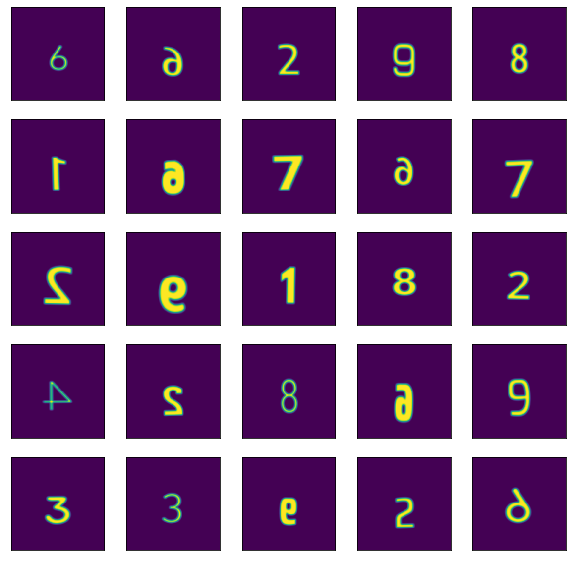

In [ ]:
sample_training_images, _ = next(train_set)
plt.figure(figsize=(10,10))
i = 0
for train_img in sample_training_images[:25]:
    plt.subplot(5,5,i+1)    # Posisción de la gráfica en la matriz
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img.squeeze(axis=2))
    i += 1

## Crating the model.

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(IMG_DIM,IMG_DIM,1), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(9, activation='softmax')
])

## Compilling model

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 50)                3175250   
                                                                 
 dense_1 (Dense)             (None, 9)                 459       
                                                                 
Total params: 3,175,869
Trainable params: 3,175,869
Non-trainable params: 0
______________________________________________

## Training the model

In [ ]:
history = model.fit_generator(
    train_set,
    epochs=EPOCHS,
    steps_per_epoch=len(train_set),
    validation_data=test_set,
    validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
88/88 [==============================] - 21s 232ms/step - loss: 0.2459 - accuracy: 0.5844 - val_loss: 0.1343 - val_accuracy: 0.8161
Epoch 2/50
88/88 [==============================] - 22s 248ms/step - loss: 0.1328 - accuracy: 0.8223 - val_loss: 0.0891 - val_accuracy: 0.9226
Epoch 3/50
88/88 [==============================] - 20s 231ms/step - loss: 0.1027 - accuracy: 0.8726 - val_loss: 0.0659 - val_accuracy: 0.9419
Epoch 4/50
88/88 [==============================] - 20s 230ms/step - loss: 0.0889 - accuracy: 0.8938 - val_loss: 0.0577 - val_accuracy: 0.9419
Epoch 5/50
88/88 [==============================] - 20s 231ms/step - loss: 0.0716 - accuracy: 0.9149 - val_loss: 0.0503 - val_accuracy: 0.9581
Epoch 6/50
88/88 [==============================] - 20s 228ms/step - loss: 0.0615 - accuracy: 0.9311 - val_loss: 0.0357 - val_accuracy: 0.9677
Epoch 7/50
88/88 [==============================] - 20s 227ms/step - loss: 0.0491 - accuracy: 0.9472 - val_loss: 0.0308 - val_accuracy: 0.9774